In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import box
import matplotlib.pyplot as plt

In [3]:
plants = gpd.read_file('../01_data/02_intermediate/plants.csv')
plants.replace('NA', np.nan, inplace=True)
plants.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)
plants = gpd.GeoDataFrame(plants, geometry=gpd.points_from_xy(plants['LONGITUDE'], plants['LATITUDE']), crs='EPSG:4326')
plants.drop(['field_1', 'STATEFIPS', 'EJ_CLUSTER','GEOID_DBL','Shape','STATENAME'], axis=1, inplace=True)

In [72]:
income = gpd.read_file('../01_data/02_intermediate/income/Census Tracts.shp')

In [5]:
income = income.to_crs("EPSG:4326")

In [73]:
income.shape

(85027, 31)

In [78]:
85027-35162

49865

In [77]:
income['Low_Income'].sum()

35162

In [76]:
income['Low_Income'] = np.where(income['Low_Income'] == 'Qualified', 1, 0)

In [7]:
income_statu = income[['GEOID','Low_Income']].copy()
plants = pd.merge(plants,income_statu)

In [4]:
RGGI = ['CT', 'DE', 'MA', 'MD', 'ME', 'NH', 'NJ', 'NY', 'RI', 'VT']
nearby = ['PA', 'VA', 'WV'] 

In [70]:
state = gpd.read_file('../01_data/02_intermediate/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')
rggi_state = state[state['STUSPS'].isin(RGGI)]

In [6]:
plants['rggi'] = np.where(plants['STATE'].isin(RGGI), 1, 0)
plants['nearby'] = np.where(plants['STATE'].isin(nearby), 1, 0)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_28252\1096548797.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(title='Plant Distribution')


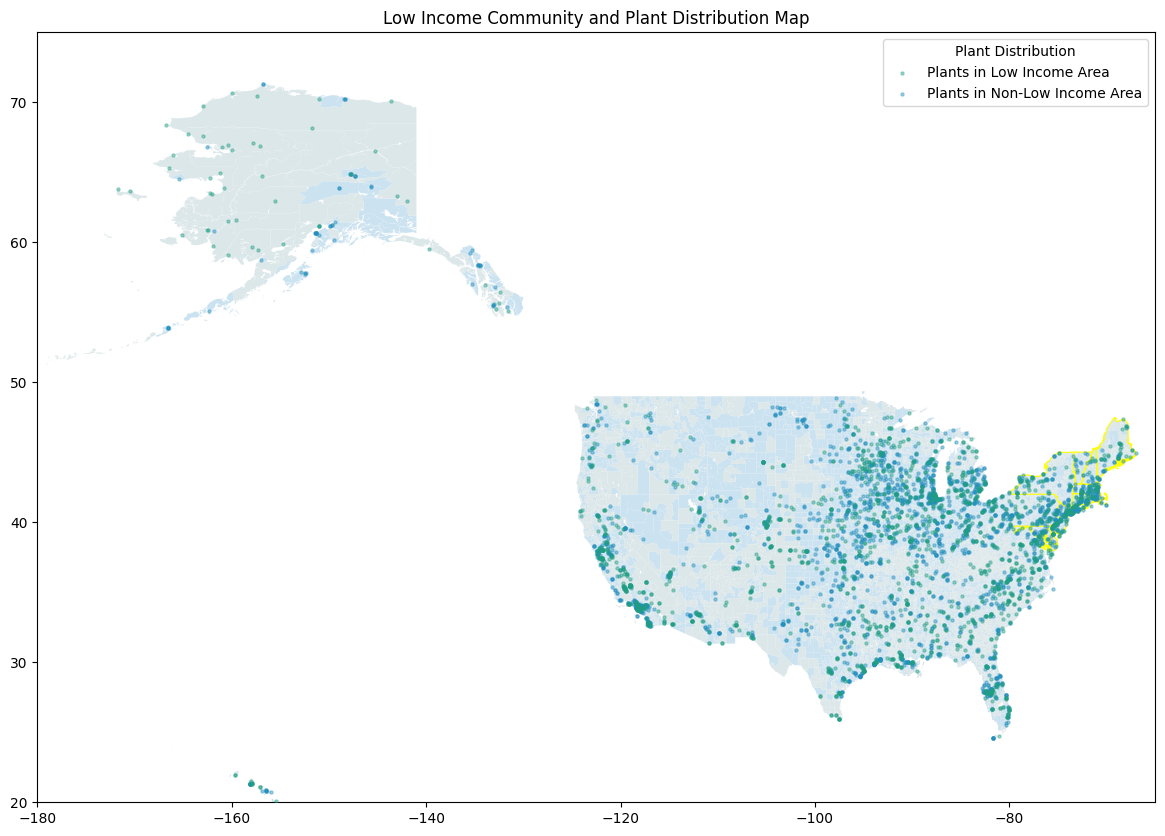

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))

income.loc[income['Low_Income'] == 1].plot(ax=ax, color='#DCE7E9',label='Low Income Communtity',zorder=2)
income.loc[income['Low_Income'] == 0].plot(ax=ax, color='#CBE2F0',zorder=1)
rggi_state.boundary.plot(ax=ax, color = 'yellow',linewidth=0.8,zorder=3)
plants.loc[plants['Low_Income'] == 1].plot(ax=ax, color='#209E85', alpha = 0.4, markersize=5, label='Plants in Low Income Area',zorder=5)
plants.loc[plants['Low_Income'] == 0].plot(ax=ax, color='#228fbd', alpha = 0.4, markersize=5, label='Plants in Non-Low Income Area',zorder=4)

ax.set_xlim([-180, -65])
ax.set_ylim([20, 75])
ax.set_title('Low Income Community and Plant Distribution Map')
ax.legend(title='Plant Distribution')
plt.show();


In [262]:
print(plants.columns)

Index(['ORSPL', 'PLANT_NAME', 'PRIME_MOVER', 'UNIT_SIZE', 'FUEL_TYPE', 'STATE',
       'County', 'LATITUDE', 'LONGITUDE', 'FIRST_YEAR_OF_OPERATION',
       ...
       'MAJ_FUEL_2013', 'MAJ_FUEL_2014', 'MAJ_FUEL_2015', 'MAJ_FUEL_2016',
       'STATE_FIPS', 'GEOID', 'CT_GEOID', 'geometry', 'Low_Income', 'rggi'],
      dtype='object', length=158)


------

In [7]:
# compare emission before 2005 and after 2008
co2_columns = [f"CO2_{year}" for year in range(1995, 2017)]
columns = ['ORSPL', 'PLANT_NAME','PRIME_MOVER','UNIT_SIZE','FUEL_TYPE', 'rggi', 'Low_Income'] + co2_columns
plants_emission = plants[columns].copy()

In [8]:
plants_emission[co2_columns] = plants_emission[co2_columns].fillna(0).astype(float)

In [9]:
result_long = plants_emission.melt(id_vars=['ORSPL', 'PLANT_NAME', 'rggi', 'Low_Income','PRIME_MOVER','UNIT_SIZE','FUEL_TYPE'],
                                   value_vars=co2_columns,
                                   var_name='Year',
                                   value_name='CO2_Emission')
result_long['Year'] = result_long['Year'].str[-4:]

In [10]:
result_long['Year'] = result_long['Year'].astype(int)
result_long['CO2_Emission'] = result_long['CO2_Emission'] * 1000000
# Create 'Post' variable where 1 indicates years after 2008, and 0 indicates on or before 2008

In [11]:
result_long['Post'] = (result_long['Year'] > 2008).astype(int)

In [12]:
rggidata = result_long.loc[result_long['rggi'] == 1]
rggidata

,ORSPL,PLANT_NAME,rggi,nearby,PRIME_MOVER,UNIT_SIZE,FUEL_TYPE,Year,CO2_Emission,Post
200,540,Branford,1,0,GT,<25,Oil,1995,0.0,0
201,542,Cos Cob,1,0,GT,<25,Oil,1995,0.0,0
202,542,Cos Cob,1,0,GT,>=25,Oil,1995,0.0,0
203,544,Devon Station,1,0,GT,<25,Oil,1995,0.0,0
204,544,Devon Station,1,0,GT,>=25,Oil,1995,0.0,0
...,...,...,...,...,...,...,...,...,...,...
117296,59717,Framingham State University Plant,1,0,IC,<25,Oil,2016,0.0,1
117304,59783,Croda Atlas Point CHP,1,0,IC,<25,-,2016,0.0,1
117311,59815,Granby LFG,1,0,IC,<25,-,2016,0.0,1
117312,59816,Nanticoke LFG,1,0,IC,<25,-,2016,0.0,1


In [13]:
add1 = pd.read_excel('../01_data/02_intermediate/rggi0008.xlsx')

In [14]:
add_long = add1.melt(id_vars=['State', 'Plant ID \n(ORIS)', 'Plant Name '],
                                   value_vars=range(2000, 2008),
                                   var_name='Year',
                                   value_name='CO2_Emission')

In [15]:
add_long.columns = ['State','ORSPL','PLANT_NAME','Year','CO2']
add_long['ORSPL'] = add_long['ORSPL'].astype(str)
add_long['Year'] = add_long['Year'].astype(int)
add_long['CO2'] = add_long['CO2'].astype(float)

In [16]:
result = pd.merge(rggidata,add_long,how='left')

In [17]:
result['CO2_Emission'] = result.apply(lambda x: x['CO2'] if pd.notna(x['CO2']) else x['CO2_Emission'], axis=1)
result.drop(['State', 'CO2'], axis=1, inplace=True)

In [18]:
add2 = pd.read_csv('../01_data/02_intermediate/rggiDataExport.csv',encoding='iso-8859-1')

In [19]:
add2 = add2.loc[add2['Year']<2018]
add2 = add2[['Year','Source Name','ORIS Code','State','CO2 Mass (Tons)']].copy()

In [20]:
add2.columns = ['Year','PLANT_NAME','ORSPL','State','CO2']
add2['ORSPL'] = add2['ORSPL'].astype(str)
add2['Year'] = add2['Year'].astype(int)
add2['CO2'] = add2['CO2'].str.replace(',', '')
add2['CO2'] = add2['CO2'].astype(float)

In [21]:
result = pd.merge(result,add2,how='left')
result['CO2_Emission'] = result.apply(lambda x: x['CO2'] if pd.notna(x['CO2']) else x['CO2_Emission'], axis=1)
result.drop(['State', 'CO2'], axis=1, inplace=True)

In [22]:
filtered_result_long = result_long[result_long['rggi'] == 0]
result = pd.concat([result, filtered_result_long])

In [23]:
result

,ORSPL,PLANT_NAME,rggi,nearby,PRIME_MOVER,UNIT_SIZE,FUEL_TYPE,Year,CO2_Emission,Post
0,540,Branford,1,0,GT,<25,Oil,1995,0.0,0
1,542,Cos Cob,1,0,GT,<25,Oil,1995,0.0,0
2,542,Cos Cob,1,0,GT,>=25,Oil,1995,0.0,0
3,544,Devon Station,1,0,GT,<25,Oil,1995,0.0,0
4,544,Devon Station,1,0,GT,>=25,Oil,1995,0.0,0
...,...,...,...,...,...,...,...,...,...,...
117342,60260,Brevig Mission,0,0,IC,<25,Oil,2016,0.0,1
117343,60263,Durham AWTF,0,0,IC,<25,-,2016,0.0,1
117345,60349,"Hill AFB LFG Facility, Bldg #737",0,0,IC,<25,-,2016,0.0,1
117346,60388,Granger Energy of Morgantown,0,1,IC,<25,-,2016,0.0,1


In [440]:
result.to_csv('../01_data/03_final/emission.csv', index=False)

----

In [17]:
plants.head()

,ORSPL,PLANT_NAME,PRIME_MOVER,UNIT_SIZE,FUEL_TYPE,STATE,County,LATITUDE,LONGITUDE,FIRST_YEAR_OF_OPERATION,...,MAJ_FUEL_2013,MAJ_FUEL_2014,MAJ_FUEL_2015,MAJ_FUEL_2016,STATE_FIPS,GEOID,CT_GEOID,geometry,Low_Income,rggi
0,3,Barry,CC,>=25,Natural Gas,AL,Mobile,31.0069007873535,-88.0102996826172,1954,...,Natural Gas,Natural Gas,Natural Gas,Natural Gas,01,01097005800,14000US01097005800,POINT (-88.01030 31.00690),0,0
1,3,Barry,ST,>=25,Coal,AL,Mobile,31.0069007873535,-88.0102996826172,1954,...,Coal,Coal,Coal,Coal,01,01097005800,14000US01097005800,POINT (-88.01030 31.00690),0,0
2,7,Gadsden,ST,>=25,Natural Gas,AL,Etowah,34.0127983093262,-85.9708023071289,1949,...,Natural Gas,Coal,Natural Gas,NaN,01,01055001300,14000US01055001300,POINT (-85.97080 34.01280),1,0
3,8,Gorgas,ST,>=25,Coal,AL,Walker,33.644344329834,-87.1964874267578,1951,...,Coal,Coal,Coal,Coal,01,01127021500,14000US01127021500,POINT (-87.19649 33.64434),1,0
4,9,Copper,GT,>=25,Natural Gas,TX,El Paso,31.7569007873535,-106.375,1980,...,Natural Gas,Natural Gas,Natural Gas,NaN,48,48141003501,14000US48141003501,POINT (-106.37500 31.75690),1,0


In [11]:
fuel_columns = [f"MAJ_FUEL_{year}" for year in range(1995, 2017)]
columns = ['ORSPL', 'PLANT_NAME','PRIME_MOVER','UNIT_SIZE','FUEL_TYPE', 'rggi', 'Low_Income','FIRST_YEAR_OF_OPERATION']+fuel_columns
plants_type = plants[columns].copy()

In [18]:
result_long = plants_type.melt(id_vars=['ORSPL', 'PLANT_NAME', 'rggi', 'Low_Income','PRIME_MOVER'],
                                   value_vars=fuel_columns,
                                   var_name='Year',
                                   value_name='fuel')
result_long['Year'] = result_long['Year'].str[-4:]
result_long['Year'] = result_long['Year'].astype(int)

In [19]:
result_long

,ORSPL,PLANT_NAME,rggi,Low_Income,PRIME_MOVER,Year,fuel
0,3,Barry,0,0,CC,1995,NaN
1,3,Barry,0,0,ST,1995,Coal
2,7,Gadsden,0,1,ST,1995,Coal
3,8,Gorgas,0,1,ST,1995,Coal
4,9,Copper,0,1,GT,1995,Natural Gas
...,...,...,...,...,...,...,...
94903,60249,Silicon Valley Clean Water,0,0,IC,2016,NaN
94904,60250,Swampy Acres,0,0,IC,2016,NaN
94905,60263,Durham AWTF,0,0,IC,2016,NaN
94906,60276,West Groton CHP,1,0,GT,2016,NaN


In [20]:
result_long.to_csv('../01_data/03_final/type.csv', index=False)

----

In [24]:
result

,ORSPL,PLANT_NAME,rggi,nearby,PRIME_MOVER,UNIT_SIZE,FUEL_TYPE,Year,CO2_Emission,Post
0,540,Branford,1,0,GT,<25,Oil,1995,0.0,0
1,542,Cos Cob,1,0,GT,<25,Oil,1995,0.0,0
2,542,Cos Cob,1,0,GT,>=25,Oil,1995,0.0,0
3,544,Devon Station,1,0,GT,<25,Oil,1995,0.0,0
4,544,Devon Station,1,0,GT,>=25,Oil,1995,0.0,0
...,...,...,...,...,...,...,...,...,...,...
117342,60260,Brevig Mission,0,0,IC,<25,Oil,2016,0.0,1
117343,60263,Durham AWTF,0,0,IC,<25,-,2016,0.0,1
117345,60349,"Hill AFB LFG Facility, Bldg #737",0,0,IC,<25,-,2016,0.0,1
117346,60388,Granger Energy of Morgantown,0,1,IC,<25,-,2016,0.0,1


In [59]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Prepare a dataset for regression by concatenating pre and post datasets and creating an interaction term
#data_did = pd.concat([data_pre_2005, data_post_2008])
data_did = result
data_did['post'] = (data_did['Year'] > 2008).astype(int)
data_did['treatment'] = data_did['nearby']
data_did['treatment_post'] = data_did['post'] * data_did['treatment']

# Define and fit the regression model
model = ols('CO2_Emission ~ treatment + post + treatment_post', data=data_did).fit()

# Extract p-value for the interaction term (DiD estimator)
p_value = model.pvalues['treatment_post']

# Create a pivot table for plotting average emissions by year and treatment status
pivot_table1 = data_did.pivot_table(values='CO2_Emission', index='Year', columns='nearby', aggfunc='sum')
pivot_table2 = data_did.pivot_table(values='CO2_Emission', index='Year', columns='rggi', aggfunc='sum')

<Figure size 1200x600 with 0 Axes>

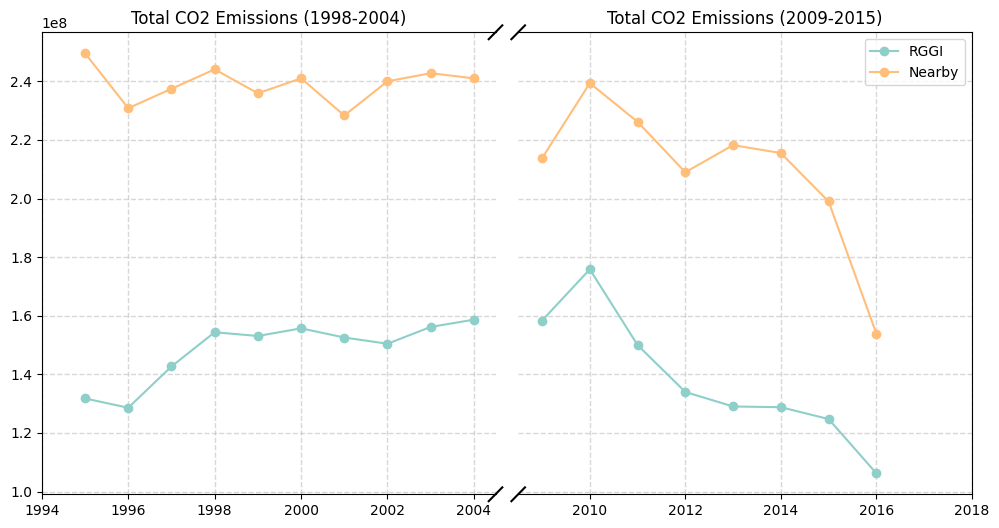

In [60]:

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Define two subplots with a shared y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
fig.subplots_adjust(wspace=0.05)  # Adjust space between the plots
colors = ['#8ECFC9','#FFBE7A']
# Plotting with standard axis for pre-2005 and post-2008
ax1.plot(pivot_table2.index[pivot_table2.index < 2005], pivot_table2[1][pivot_table2.index < 2005],color=colors[0],label='RGGI', marker='o')
ax1.plot(pivot_table1.index[pivot_table1.index < 2005], pivot_table1[1][pivot_table1.index < 2005],color=colors[1], label='Nearby', marker='o')
ax2.plot(pivot_table2.index[pivot_table2.index > 2008], pivot_table2[1][pivot_table2.index > 2008],color=colors[0], marker='o', label='RGGI')
ax2.plot(pivot_table1.index[pivot_table1.index > 2008], pivot_table1[1][pivot_table1.index > 2008],color=colors[1], marker='o', label='Nearby')

# Set the limits for the x-axis to create a broken axis effect
ax1.set_xlim(1994, 2004.5)  # data up to 2005
ax2.set_xlim(2008.5, 2018)  # data from 2008 onwards

# Hide the spines between ax1 and ax2
ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)

# Hide the y-ticks on the second subplot
ax2.tick_params(axis='y', which='both', length=0)

# Add grid lines
ax1.grid(ls='--', alpha=0.5, linewidth=1)
ax2.grid(ls='--', alpha=0.5, linewidth=1)

# Create the 'break' marks on the axes
d = .015  # length of diagonal lines at breaks
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)

# Add legends and set titles
ax2.legend(loc='upper right')
ax1.set_title('Total CO2 Emissions (1998-2004)')
ax2.set_title('Total CO2 Emissions (2009-2015)')

plt.show()

In [68]:
pivot_table1.sum(axis=1) # nearby


Year
1995    2.143609e+09
1996    2.213518e+09
1997    2.281133e+09
1998    2.359304e+09
1999    2.368084e+09
2000    2.443279e+09
2001    2.386697e+09
2002    2.416020e+09
2003    2.458419e+09
2004    2.470842e+09
2005    2.535524e+09
2006    2.488373e+09
2007    2.560058e+09
2008    2.506586e+09
2009    2.332990e+09
2010    2.486125e+09
2011    2.371733e+09
2012    2.225923e+09
2013    2.249003e+09
2014    2.244359e+09
2015    2.099930e+09
2016    1.533071e+09
dtype: float64

In [69]:
(2.099930e+09 - 2.332990e+09)/ 2.332990e+09

-0.09989755635472077

In [65]:
(1.989898e+08 - 2.137616e+08)/ 2.137616e+08

-0.06910408604726012

In [66]:
(1.065951e+08 - 1.355209e+08)/ 1.355209e+08

-0.2134416167543161

In [61]:

# Creating a table to display the data
results_table = pd.DataFrame({
    "State": ['RGGI','Nearby'],
    "1995-2004 Average Emissions": [pivot_table1[1][pivot_table2.index < 2005].sum(),pivot_table2[1][pivot_table2.index < 2005].sum()],
    "2009-2015 Average Emissions": [pivot_table1[1][pivot_table2.index > 2008].sum(),pivot_table2[1][pivot_table2.index > 2008].sum()],
    })
results_table['Change'] = results_table['2009-2015 Average Emissions']-results_table['1995-2004 Average Emissions']
results_table['Change%'] = - results_table['Change'] / results_table['1995-2004 Average Emissions'] * 100

results_table

,State,1995-2004 Average Emissions,2009-2015 Average Emissions,Change,Change%
0,RGGI,2.390924e+09,1.674880e+09,-7.160440e+08,29.948424
1,Nearby,1.484032e+09,1.106964e+09,-3.770679e+08,25.408339
